In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.interpolate import interp1d

from src.colorconv import ConvexCluster
from src.util import (non_dominated_front, 
                      compression, 
                      informativeness)

In [2]:
# unpockle IB_color_naming.pkl from data
with open('data/IB_color_naming.pkl', 'rb') as f:
    IB_color_naming = pickle.load(f)

# unpickle chip dict
with open('data/chip_dict.pkl', 'rb') as f:
    chip_dict = pickle.load(f)

# unpickle sielab_dict
with open('data/cielab_dict.pkl', 'rb') as f:
    cielab_dict = pickle.load(f)   

In [3]:
prior_m = IB_color_naming['pM']

# match index of prior_m to chip_dict coordinates 
# and build a new dict (coordinate: probability)
prior_m_ = []
for i, p in enumerate(prior_m):
    prior_m_.append((chip_dict[i+1], p))

# remove entries with first coordinate == 1
prior_m_ = [x for x in prior_m_ if x[0][1] != 0]

# use coordinate from prior_m_ to build a matrix with probabilities
prior_m_matrix = np.zeros((8, 40))
for c, p in prior_m_:
    prior_m_matrix[c[0]-1, c[1]-1] = p

In [4]:
# only choose coordinates in the range (0, 0), (8, 40)
cielab_dict_ = {k: v for k, v in cielab_dict.items() if k[0] in range(0, 9) and k[1] in range(0, 41)}

# reverse keys and values in cielab_dict_
cielab_dict_r = {v: k for k, v in cielab_dict_.items()}

# convert cielab_dict_ to a list of tuples ordered from (0, 0) to (8, 40)
cielab_list = [cielab_dict_[k] for k in sorted(cielab_dict_.keys())]

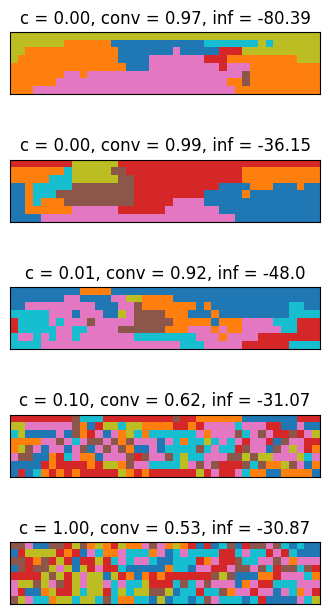

In [20]:
# just change convexity in the range 0.05 - 1
conn_values = [0.0005, 0.001, 0.01, 0.1, 1]

fig, ax = plt.subplots(5, 1, figsize=(4, 8))

for j, conn in enumerate(conn_values):
    a = ConvexCluster(X = np.zeros((8, 40)), 
                        d = 8, 
                        N = 7, 
                        s = 0.5, 
                        c = conn,
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
    labels = a.run()
    ax[j].imshow(labels, cmap='tab10', interpolation='none')
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f'c = {conn:.2f}, '
                    f'conv = {a.degree_of_convexity():.2f}, ' 
                    f'inf = {informativeness(labels, prior_m_matrix, cielab_dict).round(2)}')

In [26]:
def generate_grid(n, n_low, n_high, d = 2, X = 10, Y = 10):
    s_values = np.random.uniform(0.75, 1, n)
    c_values = np.random.uniform(0, 0.1, n)

    mdl_values = []
    conv_values = []
    cost_values = []
    categ = []
    param_dict = {}
    lgs = []

    for i, sc in enumerate(zip(s_values, c_values)):
        N = np.round(np.random.uniform(n_low, n_high), 0).astype(int)
        a = ConvexCluster(X = np.zeros((X, Y)), 
                        d = d, 
                        N = N,
                        s = sc[0], 
                        c = sc[1],
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
        l = a.run()
        
        lgs.append(l)
        param_dict[i] = (sc[0], sc[1], N)
        mdl_values.append(compression(l))
        conv_values.append(a.degree_of_convexity())
        cost_values.append(informativeness(l, 
                                           prior_m_matrix, 
                                           cielab_dict))
        categ.append(N)
    
    return mdl_values, conv_values, cost_values, categ, param_dict, lgs

In [47]:
results = generate_grid(n = 1000, 
                        d = 2, 
                        X = 8,
                        Y = 40,
                        n_low = 3,
                        n_high = 15)

In [ ]:
mdl_values, conv_values, cost_values, categ, param_dict, lgs = results

In [ ]:
# iterate over cost_values, if a value is inf, then remove it from the list and from the other lists
for i, val in enumerate(cost_values):
    if np.isinf(val):
        mdl_values.pop(i)
        conv_values.pop(i)
        categ.pop(i)
        cost_values.pop(i)

In [ ]:
pareto_front_indices = non_dominated_front(mdl_values, cost_values)
pareto_front_points = [(mdl_values[i], cost_values[i]) for i in pareto_front_indices]

# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))

x_pareto, y_pareto = zip(*pareto_front_points)

In [ ]:
# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto, frac=0.7)

In [ ]:
f = interp1d(x_pareto, y_pareto, 
             fill_value="extrapolate")

x = np.linspace(min(mdl_values), 
                max(mdl_values),  
                100)
y = f(x)

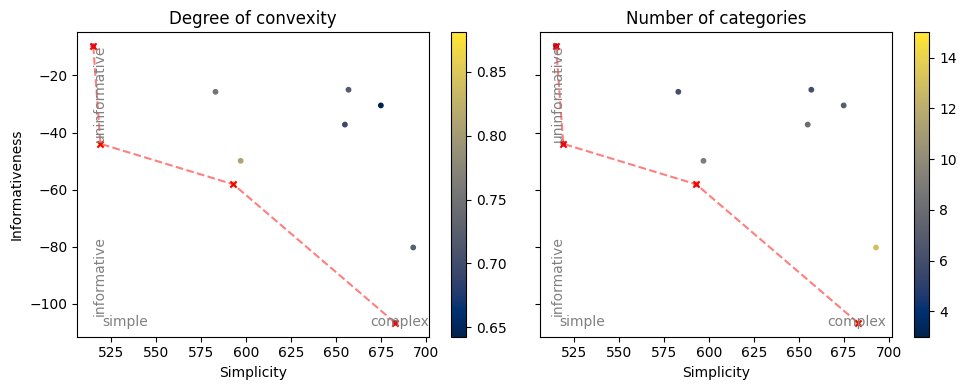

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)

# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
# ax1.plot(x, y, 'r--', linewidth=1)
ax1.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
# ax1.grid(linestyle='--', alpha=0.5)
ax1.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
ax1.text(-1.25, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.25, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.18, 0.05, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.4, 0.05, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity')
# ax1.set_xscale('log')
cbar1 = fig.colorbar(scatter1, ax=ax1)

# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
# ax2.plot(x, y, 'r--', linewidth=1)
ax2.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
# ax2.set_xlabel('simple <------------------------> complex')
# add text in the top and bottom left corner
ax2.text(0.05, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax2.text(0.05, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax2.text(0.12, 0.05, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax2.text(0.9, 0.05, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories')
# ax2.set_xscale('log')
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
# for each point in (mdl_values, cost_values), calculate the distance to the points in the pareto front
distances = []

x_pareto = np.array(x_pareto)
y_pareto = np.array(y_pareto)

for i, j in zip(mdl_values, cost_values):
    distances.append(np.min(np.sqrt((i - x_pareto)**2 + (j - y_pareto)**2)))

In [ ]:
df = pd.DataFrame({'convexity': conv_values,
                   'categories': categ,
                   'distance': distances})

In [ ]:
# standardize categories and convexity
df['categories'] = (df['categories'] - df['categories'].mean()) / df['categories'].std()
df['convexity'] = (df['convexity'] - df['convexity'].mean()) / df['convexity'].std()

In [ ]:
# statsmodels regression predicting distance from convexity and number of categories

# remove nan or inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df[['convexity', 'categories']]
y = df['distance']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

In [ ]:
# summarize our model
model.summary()

/Users/alexeykoshevoy/.pyenv/versions/3.11.2/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     5.497
Date:                Sat, 17 Feb 2024   Prob (F-statistic):             0.0367
Time:                        21:42:57   Log-Likelihood:                -43.600
No. Observations:                  10   AIC:                             93.20
Df Residuals:                       7   BIC:                             94.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.5261      7.157      3.986      0.005      11.602      45.451
convexity    -23.5531      7.601     -3.099      0.017     -41.527      -5.579
categories    -6.0350      7.601     -0.794      0.453     -24.009      11.939
==============================================================================
Omnibus:                        4.673   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                1.699
Skew:                          -0.980   Prob(JB):                        0.428
Kurtosis:                       3.489   Cond. No.                         1.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

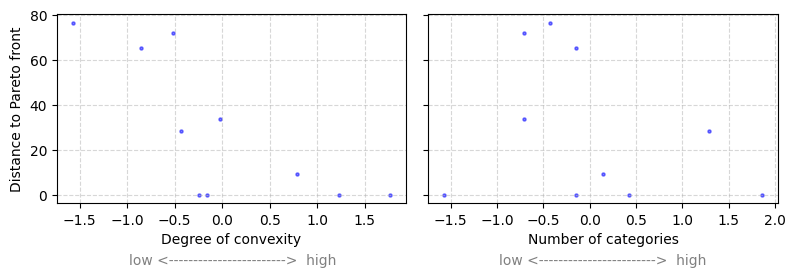

In [ ]:
# plot convexity vs distance and categories vs distance in one plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot convexity vs distance
ax1.scatter(df['convexity'], df['distance'], alpha=0.5, color='b', s=5)
ax1.grid(linestyle='--', alpha=0.5)
ax1.set_xlabel('Degree of convexity')
ax1.set_ylabel('Distance to Pareto front')
ax1.text(-0.56, -0.3, 'low <------------------------>  high', ha='center', va='center', fontsize
            =10, transform=ax2.transAxes, color = 'grey')

# Plot categories vs distance
ax2.scatter(df['categories'], df['distance'], alpha=0.5, color='b', s=5)
ax2.grid(linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of categories')
# add subscript (low <---> high) below the x-axis
ax2.text(0.5, -0.3, 'low <------------------------>  high', ha='center', va='center', fontsize
            =10, transform=ax2.transAxes, color = 'grey')
        

plt.tight_layout()
plt.show()

In [ ]:
with open('data/lg_color.pkl', 'rb') as f:
    lg_color = pickle.load(f)

In [ ]:
# enumerate over grids in lg_color and calculate informativeness
informativeness_values = []
simplicity_values = []
categ_values = []

for grid in lg_color:
    informativeness_values.append(informativeness(lg_color[grid], prior_m_matrix, cielab_dict))
    simplicity_values.append(compression(lg_color[grid]))
    categ_values.append(len(np.unique(lg_color[grid])))

In [ ]:
# count the number of unique values in each grid in lg_color
unique_values = [len(np.unique(lg_color[grid])) for grid in lg_color]
# print min and max
print(min(unique_values), max(unique_values))

3 15


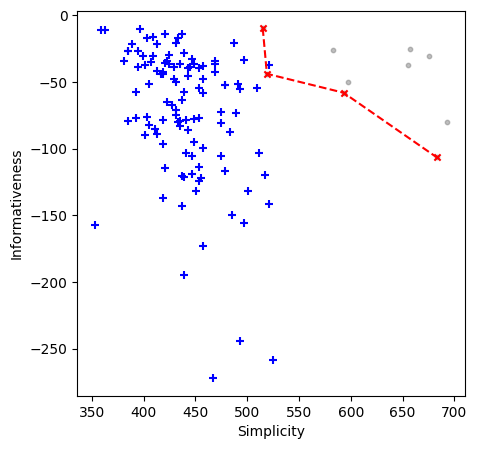

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(mdl_values, cost_values, color='gray', 
            alpha=0.5, s=10)
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r--')
plt.scatter(simplicity_values, informativeness_values, 
            c='blue', alpha=1, marker='+', s=40)
plt.scatter(*zip(*pareto_front_points), 
            c='red', 
            marker='x',
            s=20)
plt.ylabel('Informativeness')
plt.xlabel('Simplicity')
plt.show()